In [1]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt

In [2]:
#Authenticate to the Earth Engine servers
ee.Authenticate()

True

In [3]:
#Initialize ee
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [4]:
#Load the lake geojson
lake = gpd.read_file('Lake_Victoria_Shapefile.geojson')
lake.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

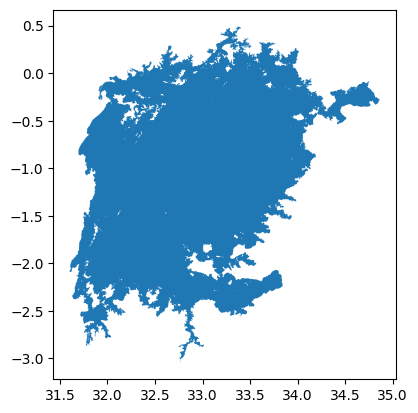

In [5]:
lake.plot()

In [6]:
#Load Kenya geojson
kenya = gpd.read_file('kenya.geojson')
kenya.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
kenya.head()

,id,abbreviati,country_co,country_na,wld_rgn,geometry
0,000000000000000000c6,,KE,Kenya,Africa,"MULTIPOLYGON (((40.9479 -2.22394, 40.94743 -2...."


<Axes: >

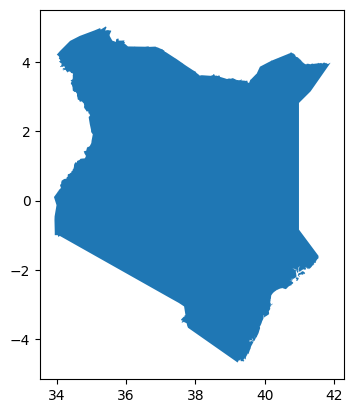

In [8]:
kenya.plot()

In [9]:
# #Our study area is the intersection of the two
# study_area = gpd.overlay(kenya, lake, how='intersection')
# study_area.plot()

In [10]:
# study_area.explore()

In [11]:
# #Export it as shapefile
# study_area.to_file('study_area.shp')

In [12]:
#Load the study area asset uploaded to ee
lake_asset = 'projects/water-quality-441207/assets/lake_victoria_ke'
lake = ee.FeatureCollection(lake_asset)

In [13]:
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [14]:
#Load the MODIS image collection
dataset = ee.ImageCollection('MODIS/061/MYD09GA') \
            .filterDate('2002-07-04', '2024-11-12') \
            .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 
                     'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'])

In [15]:
# Calculate indices for water quality
def calculate_indices(image):
    ndci = image.normalizedDifference(['sur_refl_b05', 'sur_refl_b04']).rename('NDCI')  # NIR and Red
    chl_a = image.expression(
        'exp(0.15 * (B3 / B4))',  # Empirical formula with Blue (B3) and Green (B4)
        {'B3': image.select('sur_refl_b03'), 'B4': image.select('sur_refl_b04')}
    ).rename('Chlorophyll_a')
    ssc = image.expression(
        '0.1 * pow(B3, 1.5)',  # Example SSC formula using Red (B3)
        {'B3': image.select('sur_refl_b03')}
    ).rename('SSC')
    turbidity = image.expression(
        '0.02 * pow(B3, 1.3)',  # Example Turbidity formula using Red (B3)
        {'B3': image.select('sur_refl_b03')}
    ).rename('Turbidity')
    return image.addBands([ndci, chl_a, ssc, turbidity])

# Apply index calculations to the dataset
processed_dataset = dataset.map(calculate_indices)

In [16]:
# Define the region of interest
lake_geometry = lake.geometry()

In [17]:
# Define the date range
start_date = '2002-07-04'
end_date = '2024-11-12'

In [ ]:
# Define the function to compute monthly NDCI averages
def compute_monthly_ndci_averages(start_date, end_date, lake, scale=1000):
    # Define the date range
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    
    # Generate a list of months
    months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

    all_stats = []

    for month in months:
        month_start = ee.Date(f'{month}-01')
        month_end = month_start.advance(1, 'month')
        
        # Filter the dataset for the month and select the NDCI band
        monthly_ndci = processed_dataset.filterDate(month_start, month_end).select('NDCI').mean()
        
        # Ensure the image has the band
        if monthly_ndci.bandNames().size().getInfo() == 0:
            print(f"No data for {month}")
            continue
        
        # Compute the zonal statistics for the region
        stats = geemap.zonal_stats(
            monthly_ndci, 
            lake, 
            None,  # No need to save intermediate files
            stat_type='MEAN', 
            scale=scale, 
            return_fc=True
        )
        
        # Convert the results to a DataFrame and add the month column
        df = geemap.ee_to_df(stats)
        df['month'] = month
        all_stats.append(df)
    
    # Concatenate all monthly DataFrames into a single DataFrame
    final_df = pd.concat(all_stats, ignore_index=True)
    
    # Save the final DataFrame to a CSV file
    final_output_file = 'monthly_ndci_averages.csv'
    final_df.to_csv(final_output_file, index=False)
    
    return final_output_file

In [24]:
# Compute the monthly NDCI averages
final_output_file = compute_monthly_ndci_averages(start_date, end_date, lake)
print(f'Monthly NDCI averages saved to {final_output_file}')

Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...


In [ ]:
# Define the function to compute monthly Chlorophyll_a averages
def compute_monthly_chlorophyll_a_averages(start_date, end_date, lake, scale=500):
    # Define the date range
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    
    # Generate a list of months
    months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

    all_stats = []

    for month in months:
        month_start = ee.Date(f'{month}-01')
        month_end = month_start.advance(1, 'month')
        
        # Filter the dataset for the month and select the NDCI band
        monthly_ndci = processed_dataset.filterDate(month_start, month_end).select('Chlorophyll_a').mean()
        
        # Ensure the image has the band
        if monthly_ndci.bandNames().size().getInfo() == 0:
            print(f"No data for {month}")
            continue
        
        # Compute the zonal statistics for the region
        stats = geemap.zonal_stats(
            monthly_ndci, 
            lake, 
            None,  # No need to save intermediate files
            stat_type='MEAN', 
            scale=scale, 
            return_fc=True
        )
        
        # Convert the results to a DataFrame and add the month column
        df = geemap.ee_to_df(stats)
        df['month'] = month
        all_stats.append(df)
    
    # Concatenate all monthly DataFrames into a single DataFrame
    final_df = pd.concat(all_stats, ignore_index=True)
    
    # Save the final DataFrame to a CSV file
    final_output_file = 'monthly_Chlorophyll_a_averages.csv'
    final_df.to_csv(final_output_file, index=False)
    
    return final_output_file

In [30]:
# Compute the monthly chlorophyll-a averages
final_output_file = compute_monthly_chlorophyll_a_averages(start_date, end_date, lake)
print(f'Monthly chlorophyll-a averages saved to {final_output_file}')

Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...


In [32]:
# Define the function to compute monthly SSC averages
def compute_monthly_SSC_averages(start_date, end_date, lake, scale=500):
    # Define the date range
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    
    # Generate a list of months
    months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

    all_stats = []

    for month in months:
        month_start = ee.Date(f'{month}-01')
        month_end = month_start.advance(1, 'month')
        
        # Filter the dataset for the month and select the NDCI band
        monthly_SSC = processed_dataset.filterDate(month_start, month_end).select('SSC').mean()
        
        # Ensure the image has the band
        if monthly_SSC.bandNames().size().getInfo() == 0:
            print(f"No data for {month}")
            continue
        
        # Compute the zonal statistics for the region
        stats = geemap.zonal_stats(
            monthly_SSC, 
            lake, 
            None,  # No need to save intermediate files
            stat_type='MEAN', 
            scale=scale, 
            return_fc=True
        )
        
        # Convert the results to a DataFrame and add the month column
        df = geemap.ee_to_df(stats)
        df['month'] = month
        all_stats.append(df)
    
    # Concatenate all monthly DataFrames into a single DataFrame
    final_df = pd.concat(all_stats, ignore_index=True)
    
    # Save the final DataFrame to a CSV file
    final_output_file = 'monthly_SSC_a_averages.csv'
    final_df.to_csv(final_output_file, index=False)
    
    return final_output_file

In [33]:
# Compute the monthly SSC averages
final_output_file = compute_monthly_SSC_averages(start_date, end_date, lake)
print(f'Monthly SSC averages saved to {final_output_file}')

Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...


In [ ]:
# Define the function to compute monthly turbidity averages
def compute_monthly_turbidity_averages(start_date, end_date, lake, scale=500):
    # Define the date range
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    
    # Generate a list of months
    months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

    all_stats = []

    for month in months:
        month_start = ee.Date(f'{month}-01')
        month_end = month_start.advance(1, 'month')
        
        # Filter the dataset for the month and select the NDCI band
        monthly_turbidity = processed_dataset.filterDate(month_start, month_end).select('Turbidity').mean()
        
        # Ensure the image has the band
        if monthly_turbidity.bandNames().size().getInfo() == 0:
            print(f"No data for {month}")
            continue
        
        # Compute the zonal statistics for the region
        stats = geemap.zonal_stats(
            monthly_turbidity, 
            lake, 
            None,  # No need to save intermediate files
            stat_type='MEAN', 
            scale=scale, 
            return_fc=True
        )
        
        # Convert the results to a DataFrame and add the month column
        df = geemap.ee_to_df(stats)
        df['month'] = month
        all_stats.append(df)
    
    # Concatenate all monthly DataFrames into a single DataFrame
    final_df = pd.concat(all_stats, ignore_index=True)
    
    # Save the final DataFrame to a CSV file
    final_output_file = 'monthly_turbidity_averages.csv'
    final_df.to_csv(final_output_file, index=False)
    
    return final_output_file

In [36]:
# Compute the monthly Turbidity averages
final_output_file = compute_monthly_turbidity_averages(start_date, end_date, lake)
print(f'Monthly turbidity averages saved to {final_output_file}')

Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
Computing statistics ...
